## Importación de librerias

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math 


## Codigo simple para red cuadrada

✅ Magnetización promedio (ensemble): -0.002400 ± 0.002407

🔄 Calculando m vs H...


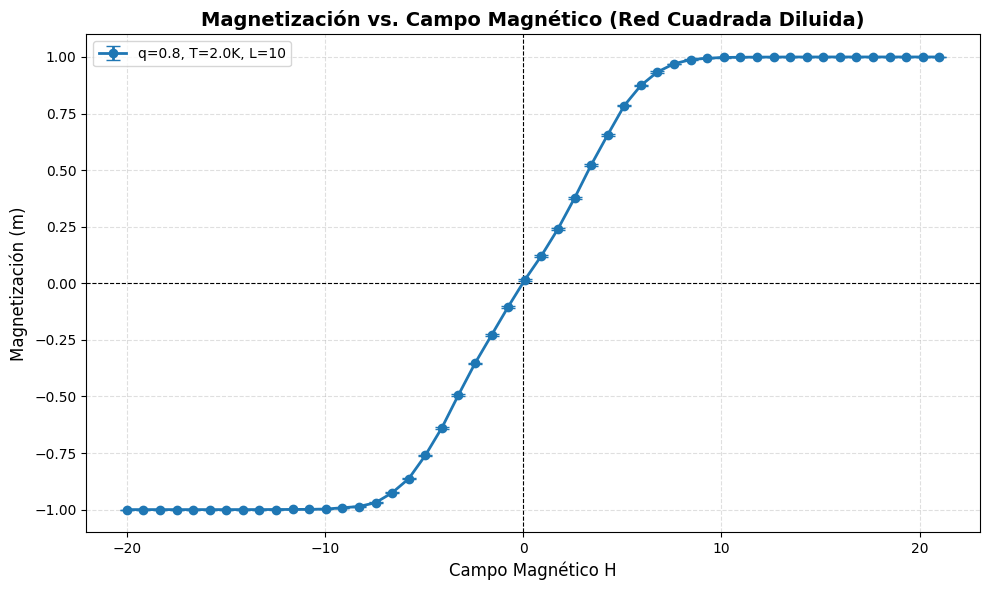

✅ Simulación completada correctamente


In [21]:
### CÓDIGO CORREGIDO PARA RED CUADRADA (SQUARE LATTICE)

import numpy as np
import matplotlib.pyplot as plt
import random
import math

def build_system(L, q):
    """Construye el sistema con spins aleatorios en una red square diluida"""
    N = L * L
    n = int(q * N)
    Ss = np.zeros((L, L), dtype=int)
    posiciones_totales = [(i, j) for i in range(L) for j in range(L)]
    random.shuffle(posiciones_totales)
    posiciones_ocupadas = []
    
    for k in range(n):
        i, j = posiciones_totales[k]
        Ss[i, j] = random.choice([-1, 1])
        posiciones_ocupadas.append((i, j))
    
    return Ss, posiciones_ocupadas, n


def get_neighbors(i, j, L):
    """Retorna los 4 vecinos en la red square con condiciones periódicas"""
    return [
        (i % L, (j + 1) % L),  # Derecha
        (i % L, (j - 1) % L),  # Izquierda
        ((i + 1) % L, j % L),  # Abajo
        ((i - 1) % L, j % L)   # Arriba
    ]


def delta_energy(spin, i, j, H, J, L):  # ⬅️ SIN 'u'
    """Calcula el cambio de energía al flipear un spin"""
    sigma = spin[i, j]  # ⬅️ 2D
    neighbors = get_neighbors(i, j, L)  # ⬅️ SIN 'u'
    
    sum_vecinos = sum(spin[ni, nj] for ni, nj in neighbors if spin[ni, nj] != 0)  # ⬅️ SIN 'nu'
    
    energia_local = -J * sigma * sum_vecinos + sigma * H
    return 2 * energia_local


def simulate(L, q, J, H, T, steps_equil=10000, steps_meas=10000, measure_every=100):
    """Simula una realización del sistema usando Monte Carlo (Metropolis)"""
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return 0.0
    
    suma_spins = np.sum(spin)
    
    # Fase de equilibración
    for _ in range(steps_equil):
        i, j = random.choice(occupied)  # ⬅️ SIN 'u'
        Delta_E = delta_energy(spin, i, j, H, J, L)  # ⬅️ SIN 'u'
        
        if Delta_E <= 0 or math.exp(-Delta_E / T) > random.random():
            suma_spins -= 2 * spin[i, j]  # ⬅️ 2D
            spin[i, j] *= -1
    
    # Fase de medición
    m_samples = []
    for step in range(steps_meas):
        i, j = random.choice(occupied)  # ⬅️ SIN 'u'
        Delta_E = delta_energy(spin, i, j, H, J, L)  # ⬅️ SIN 'u'
        
        if Delta_E <= 0 or math.exp(-Delta_E / T) > random.random():
            suma_spins -= 2 * spin[i, j]  # ⬅️ 2D
            spin[i, j] *= -1
        
        if step % measure_every == 0:
            m = suma_spins / n
            m_samples.append(m)
    
    return np.mean(m_samples)


def simulate_ensemble(L, q, J, H, T, num_realizaciones=10, steps_equil=10000, 
                     steps_meas=10000, measure_every=100):
    """Promedia sobre múltiples realizaciones del desorden"""
    m_locals = []
    for _ in range(num_realizaciones):
        m_local = simulate(L, q, J, H, T, steps_equil, steps_meas, measure_every)
        m_locals.append(m_local)
    
    m_final = np.mean(m_locals)
    error = np.std(m_locals) / np.sqrt(num_realizaciones)
    return m_final, error


# --- PRUEBA ---
L = 10
q = 0.8
J = 1.0
H = 0.0
T = 2.0
num_realizaciones = 10

m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones)
print(f"✅ Magnetización promedio (ensemble): {m:.6f} ± {err:.6f}")


# --- GRÁFICA DE PRUEBA: m vs H ---
H_values = np.linspace(-20, 21, 50)
magnetizations = []
errors = []

print("\n🔄 Calculando m vs H...")
for H in H_values:
    m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones, 
                               steps_equil=5000, steps_meas=5000)
    magnetizations.append(m)
    errors.append(err)

plt.figure(figsize=(10, 6))
plt.errorbar(H_values, magnetizations, yerr=errors, 
             fmt='o-', capsize=5, markersize=6, linewidth=2, 
             label=f'q={q}, T={T}K, L={L}')
plt.xlabel('Campo Magnético H', fontsize=12)
plt.ylabel('Magnetización (m)', fontsize=12)
plt.title('Magnetización vs. Campo Magnético (Red Cuadrada Diluida)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.4)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

print("✅ Simulación completada correctamente")

## Codigo optimizado con numba

In [22]:
### CÓDIGO OPTIMIZADO CON NUMBA PARA RED CUADRADA

import numpy as np
import matplotlib.pyplot as plt
from numba import njit

def build_system(L, q):
    """Construye el sistema con spins aleatorios en una red cuadrada diluida"""
    N = L * L
    n = int(q * N)
    Ss = np.zeros((L, L), dtype=np.int32)
    if n == 0:
        return Ss, np.zeros((0, 2), dtype=np.int32), 0
    
    # Generar todas las posiciones
    i_coords = np.repeat(np.arange(L), L)
    j_coords = np.tile(np.arange(L), L)
    all_pos = np.column_stack((i_coords, j_coords))
    
    # Seleccionar posiciones ocupadas aleatoriamente
    idx = np.random.choice(N, n, replace=False)
    posiciones_ocupadas = all_pos[idx]
    
    # Asignar spins aleatorios
    signs = np.random.choice(np.array([-1, 1], dtype=np.int32), n)
    Ss[posiciones_ocupadas[:, 0], posiciones_ocupadas[:, 1]] = signs
    
    return Ss, posiciones_ocupadas, n

@njit
def delta_energy(spin, i, j, H, J, L):
    """Calcula el cambio de energía al flipear un spin"""
    sigma = spin[i, j]
    sum_vecinos = 0
    
    # 4 vecinos en red cuadrada con condiciones periódicas
    n1i, n1j = i % L, (j + 1) % L  # Derecha
    n2i, n2j = i % L, (j - 1) % L  # Izquierda
    n3i, n3j = (i + 1) % L, j % L  # Abajo
    n4i, n4j = (i - 1) % L, j % L  # Arriba
    
    if spin[n1i, n1j] != 0:
        sum_vecinos += spin[n1i, n1j]
    if spin[n2i, n2j] != 0:
        sum_vecinos += spin[n2i, n2j]
    if spin[n3i, n3j] != 0:
        sum_vecinos += spin[n3i, n3j]
    if spin[n4i, n4j] != 0:
        sum_vecinos += spin[n4i, n4j]
    
    energia_local = -J * sigma * sum_vecinos + sigma * H
    return 2 * energia_local

@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """Fase de equilibración optimizada"""
    for _ in range(steps_equil):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        Delta_E = delta_energy(spin, i, j, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j]
            spin[i, j] = -spin[i, j]
    return suma_spins

@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """Fase de medición optimizada"""
    num_samples = (steps_meas // measure_every) + 1 if steps_meas % measure_every != 0 else (steps_meas // measure_every)
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        Delta_E = delta_energy(spin, i, j, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j]
            spin[i, j] = -spin[i, j]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return m_samples[:cnt]

def simulate(L, q, J, H, T, steps_equil=10000, steps_meas=10000, measure_every=100):
    """Simula una realización del sistema usando Monte Carlo (Metropolis)"""
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return 0.0
    
    # Calcular suma solo de spins ocupados
    suma_spins = 0
    for k in range(n):
        i, j = occupied[k]
        suma_spins += spin[i, j]
    
    # Fase de equilibración
    suma_spins = equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
    
    # Fase de medición
    m_samples = measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
    
    return np.mean(m_samples)

def simulate_ensemble(L, q, J, H, T, num_realizaciones=10, steps_equil=10000,
                      steps_meas=10000, measure_every=100):
    """Promedia sobre múltiples realizaciones del desorden"""
    m_locals = []
    for _ in range(num_realizaciones):
        m_local = simulate(L, q, J, H, T, steps_equil, steps_meas, measure_every)
        m_locals.append(m_local)
    m_final = np.mean(m_locals)
    error = np.std(m_locals) / np.sqrt(num_realizaciones)
    return m_final, error

# ============ PRUEBA ============
L = 10
q = 0.8
J = 1.0
H = 0.0
T = 2.0
num_realizaciones = 10

print("⏳ Ejecutando simulación optimizada con Numba para red cuadrada...")
m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones)
print(f"✅ Magnetización promedio (ensemble): {m:.6f} ± {err:.6f}")

⏳ Ejecutando simulación optimizada con Numba para red cuadrada...
✅ Magnetización promedio (ensemble): 0.002450 ± 0.004718
✅ Magnetización promedio (ensemble): 0.002450 ± 0.004718


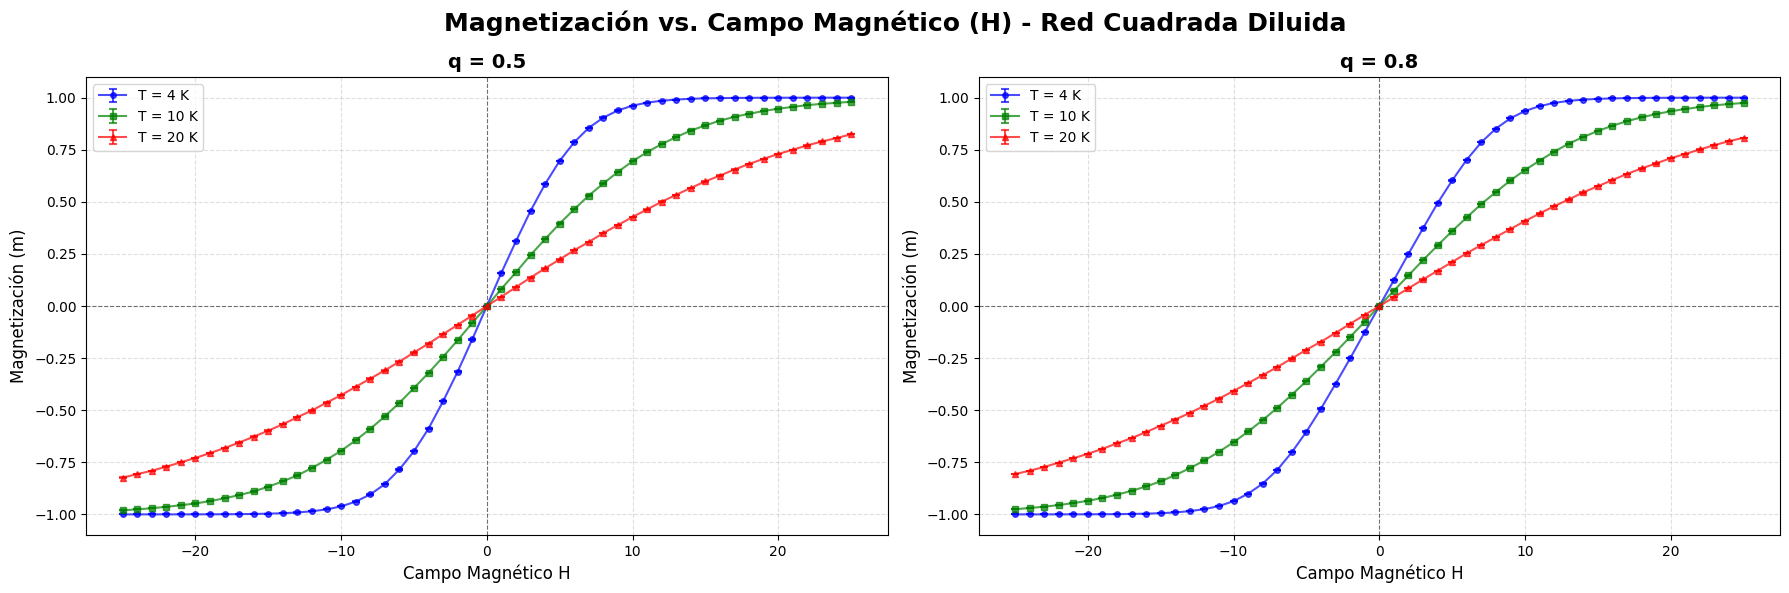

In [23]:
# --- 1. Definición de Parámetros ---
L = 10
J = 1.0
H_values = np.linspace(-25, 25, 51)  # 51 puntos para el campo magnético
q_values = [ 0.5, 0.8]
T_values = [4, 10, 20]
num_realizaciones = 100  # Aumentado para mayor precisión
steps_equil = 10000
steps_meas = 20000

# Diccionario para almacenar los resultados
results = {}

# --- 2. Bucle de Simulación ---
for q in q_values:
    for T in T_values:
        ##print(f"--- Iniciando simulación para q = {q}, T = {T} K ---")
        
        # Listas para guardar magnetización y error
        magnetizations = []
        errors = []
        
        # Iterar sobre cada valor de H
        for H in H_values:
            ##print(f"  Calculando para H = {H:.1f}...")
            m, err = simulate_ensemble(
                L=L, 
                q=q, 
                J=J, 
                H=H, 
                T=T, 
                num_realizaciones=num_realizaciones,
                steps_equil=steps_equil,
                steps_meas=steps_meas
            )
            magnetizations.append(m)
            errors.append(err)
        
        # Guardar los resultados para esta combinación de (q, T)
        results[(q, T)] = {'m': magnetizations, 'err': errors}
        ##print(f"--- Simulación para q = {q}, T = {T} K completada ---\n")

##print("✅ Todas las simulaciones han finalizado.")

# --- 3. Visualización de Resultados (3 gráficas, una por cada q) ---
fig, axes = plt.subplots(1, len(q_values), figsize=(18, 6))
fig.suptitle('Magnetización vs. Campo Magnético (H) - Red Cuadrada Diluida', fontsize=18, fontweight='bold')

# Colores para cada temperatura
colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i, q in enumerate(q_values):
    ax = axes[i]
    
    # Graficar cada temperatura en la misma gráfica
    for j, T in enumerate(T_values):
        res = results[(q, T)]
        ax.errorbar(
            H_values, 
            res['m'],
            yerr=res['err'],
            fmt=f'-{markers[j]}', 
            markersize=4, 
            color=colors[j],
            label=f'T = {T} K',
            capsize=3,
            capthick=1.5,
            elinewidth=1.5,
            alpha=0.7
        )
    
    # Configuración de la gráfica
    ax.set_title(f'q = {q}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Campo Magnético H', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='best', fontsize=10)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()


## Ciclo de relajacion


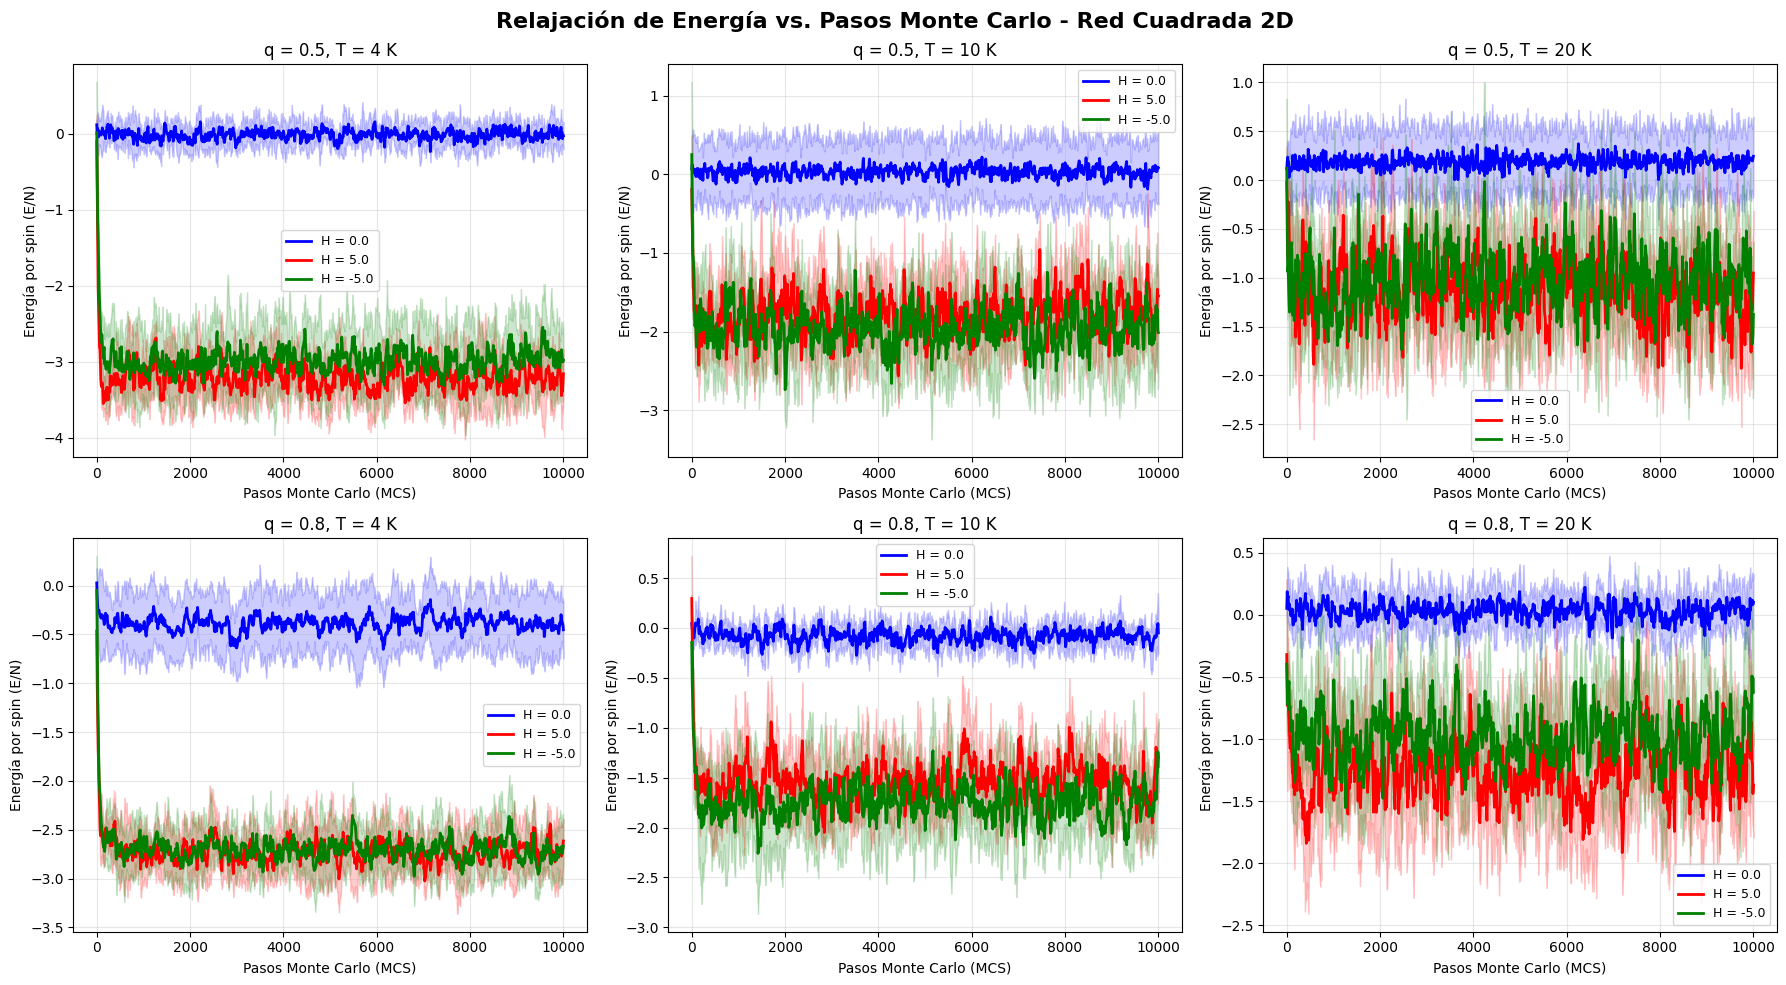

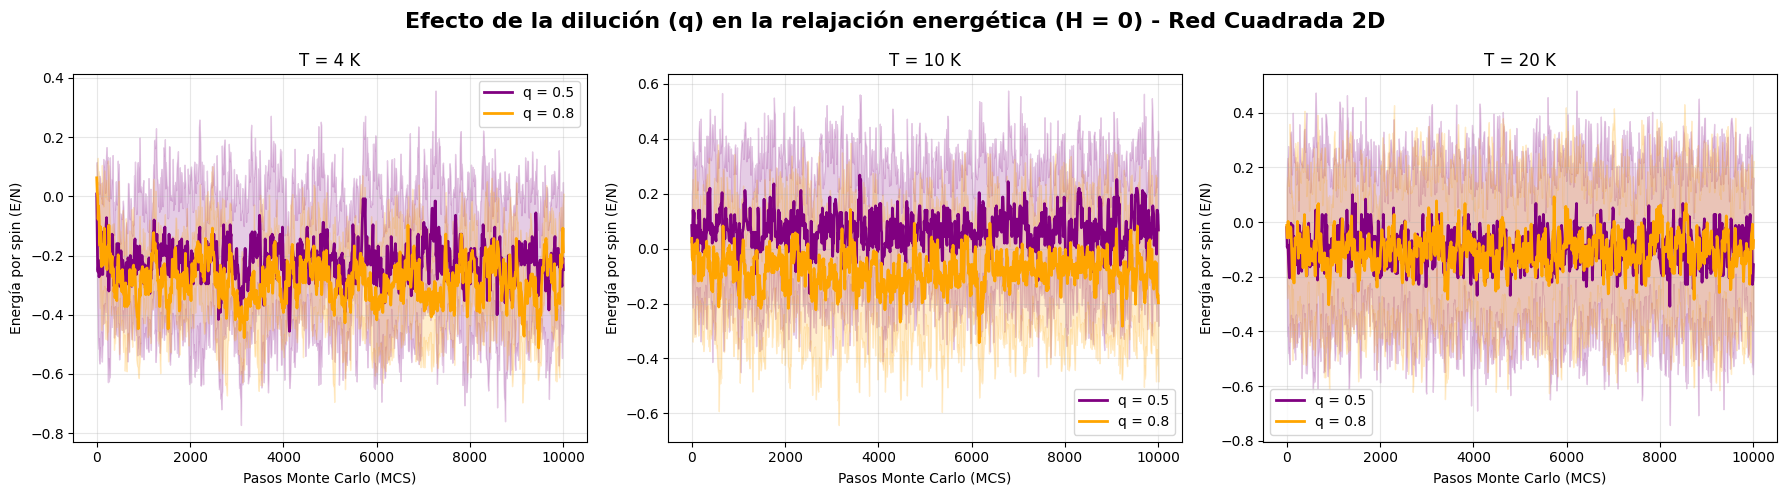

In [24]:
### Funciones adicionales para análisis de relajación energética - Red Cuadrada 2D

@njit
def calculate_total_energy(spin, occupied, L, J, H):
    """
    Calcula la energía total del sistema en red cuadrada 2D
    E = -J * Σ(σi*σj) - H * Σ(σi)
    donde la suma es sobre todos los pares vecinos (4 vecinos por sitio)
    
    Args:
        spin: Array 2D de spins (L×L)
        occupied: Array de posiciones ocupadas (n×2)
        L: Tamaño de la red cuadrada (L×L)
        J: Constante de acoplamiento
        H: Campo magnético externo
    
    Returns:
        energy: Energía total del sistema
    """
    # Calcula el número de sitios ocupados basándose en la forma del array
    n = occupied.shape[0]
    # Inicializa la energía total en cero
    energy = 0.0
    
    # Itera sobre cada sitio ocupado para calcular su contribución energética
    for k in range(n):
        # Obtiene las coordenadas (i, j) del sitio ocupado actual
        i = occupied[k, 0]
        j = occupied[k, 1]
        # Obtiene el valor del spin en ese sitio
        sigma = spin[i, j]
        
        # Calcula los índices de los 4 vecinos con condiciones periódicas
        n1i, n1j = i % L, (j + 1) % L  # Vecino derecha
        n2i, n2j = i % L, (j - 1) % L  # Vecino izquierda
        n3i, n3j = (i + 1) % L, j % L  # Vecino abajo
        n4i, n4j = (i - 1) % L, j % L  # Vecino arriba
        
        # Suma las contribuciones de los vecinos ocupados (spin != 0)
        sum_vecinos = 0
        # Verifica si el vecino derecha está ocupado
        if spin[n1i, n1j] != 0:
            sum_vecinos += spin[n1i, n1j]
        # Verifica si el vecino izquierda está ocupado
        if spin[n2i, n2j] != 0:
            sum_vecinos += spin[n2i, n2j]
        # Verifica si el vecino abajo está ocupado
        if spin[n3i, n3j] != 0:
            sum_vecinos += spin[n3i, n3j]
        # Verifica si el vecino arriba está ocupado
        if spin[n4i, n4j] != 0:
            sum_vecinos += spin[n4i, n4j]
        
        # Energía de interacción dividida por 2 para evitar contar dos veces cada enlace
        energy += -J * sigma * sum_vecinos / 2.0
        
        # Energía del campo magnético externo (término Zeeman)
        energy += -H * sigma
    
    # Retorna la energía total calculada
    return energy

@njit
def simulate_with_energy_tracking(spin, occupied, L, n, max_steps, H, J, T, record_every=10):
    """
    Simula el sistema y registra la evolución de energía vs pasos Monte Carlo
    
    Args:
        spin: Array 2D de spins inicial (L×L)
        occupied: Array de posiciones ocupadas (n×2)
        L: Tamaño de la red cuadrada
        n: Número de sitios ocupados
        max_steps: Número máximo de pasos Monte Carlo
        H: Campo magnético externo
        J: Constante de acoplamiento
        T: Temperatura
        record_every: Frecuencia de registro (cada cuántos pasos se guarda)
    
    Returns:
        mcs_array: Array con los pasos Monte Carlo registrados
        energy_array: Array con las energías registradas
    """
    # Calcula cuántos registros se harán durante la simulación
    num_records = (max_steps // record_every) + 1
    # Crea array para almacenar los pasos Monte Carlo registrados
    mcs_array = np.zeros(num_records)
    # Crea array para almacenar las energías registradas
    energy_array = np.zeros(num_records)
    
    # Calcula la energía inicial del sistema
    energy = calculate_total_energy(spin, occupied, L, J, H)
    # Registra el paso inicial (0)
    mcs_array[0] = 0
    # Registra la energía inicial
    energy_array[0] = energy
    
    # Inicializa el contador de registros
    cnt = 1
    # Itera sobre cada paso Monte Carlo desde 1 hasta max_steps
    for step in range(1, max_steps + 1):
        # Selecciona aleatoriamente un spin ocupado
        k = np.random.randint(n)
        # Obtiene las coordenadas (i, j) del spin seleccionado
        i = occupied[k, 0]
        j = occupied[k, 1]
        
        # Calcula el cambio de energía si se voltea el spin
        Delta_E = delta_energy(spin, i, j, H, J, L)
        
        # Criterio de aceptación de Metropolis-Hastings
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            # Acepta el movimiento: voltea el spin
            spin[i, j] = -spin[i, j]
            # Actualiza la energía total con el cambio
            energy += Delta_E
        
        # Registra la energía cada 'record_every' pasos
        if step % record_every == 0:
            # Guarda el número de paso Monte Carlo
            mcs_array[cnt] = step
            # Guarda la energía en ese paso
            energy_array[cnt] = energy
            # Incrementa el contador de registros
            cnt += 1
    
    # Retorna los arrays recortados hasta el número real de registros
    return mcs_array[:cnt], energy_array[:cnt]

def run_energy_relaxation(L, q, J, H, T, max_steps=10000, record_every=10):
    """
    Ejecuta una simulación completa y retorna la evolución temporal de la energía
    
    Args:
        L: Tamaño de la red cuadrada (L×L)
        q: Concentración de sitios ocupados
        J: Constante de acoplamiento
        H: Campo magnético externo
        T: Temperatura
        max_steps: Número máximo de pasos Monte Carlo
        record_every: Frecuencia de registro
    
    Returns:
        mcs: Array de pasos Monte Carlo
        energies_per_spin: Array de energía por spin
    """
    # Construye el sistema con configuración inicial aleatoria
    spin, occupied, n = build_system(L, q)
    # Si no hay spins ocupados, retorna arrays con un solo elemento cero
    if n == 0:
        return np.array([0]), np.array([0])
    
    # Ejecuta la simulación con seguimiento de energía
    mcs, energies = simulate_with_energy_tracking(
        spin, occupied, L, n, max_steps, H, J, T, record_every
    )
    
    # Normaliza la energía por el número de spins ocupados
    energies_per_spin = energies / n
    
    # Retorna los pasos Monte Carlo y la energía por spin
    return mcs, energies_per_spin

### Análisis de relajación energética para red cuadrada 2D

# Define el tamaño de la red cuadrada (10×10 = 100 sitios)
L = 10
# Define la constante de acoplamiento ferromagnético
J = 1.0
# Define dos valores de concentración de sitios ocupados (50% y 80%)
q_values = [0.5, 0.8]
# Define tres valores de temperatura para las simulaciones (4K, 10K, 20K)
T_values = [4, 10, 20]
# Define tres valores de campo magnético para analizar (0, 5, -5)
H_values_relax = [0.0, 5.0, -5.0]
# Define el número máximo de pasos Monte Carlo (10^4 pasos)
max_steps = 10000
# Define cada cuántos pasos se registra la energía (cada 10 pasos)
record_every = 10
# Define el número de realizaciones del desorden para promediar (5 realizaciones)
num_realizaciones = 5

# Crea figura con subplots: len(q_values) filas x len(T_values) columnas
fig, axes = plt.subplots(len(q_values), len(T_values), figsize=(18, 10))
# Define el título principal de la figura
fig.suptitle('Relajación de Energía vs. Pasos Monte Carlo - Red Cuadrada 2D', fontsize=16, fontweight='bold')

# Define lista de colores para distinguir los tres campos magnéticos
colors_H = ['blue', 'red', 'green']

# Itera sobre cada valor de concentración q con su índice
for i, q in enumerate(q_values):
    # Itera sobre cada valor de temperatura T con su índice
    for j, T in enumerate(T_values):
        # Selecciona el eje correspondiente para esta combinación (q,T)
        ax = axes[i, j]
        
        # Itera sobre cada valor de campo magnético H con su índice
        for idx, H in enumerate(H_values_relax):
            # Crea listas vacías para almacenar resultados de múltiples realizaciones
            all_mcs = []
            all_energies = []
            
            # Ejecuta múltiples realizaciones del desorden
            for _ in range(num_realizaciones):
                # Ejecuta la simulación de relajación energética
                mcs, energies = run_energy_relaxation(L, q, J, H, T, max_steps, record_every)
                # Verifica que se hayan registrado al menos 2 puntos
                if len(mcs) > 1:
                    # Almacena los pasos Monte Carlo
                    all_mcs.append(mcs)
                    # Almacena las energías por spin
                    all_energies.append(energies)
            
            # Si hay datos válidos de las realizaciones
            if all_energies:
                # Calcula la energía promedio sobre todas las realizaciones
                mean_energies = np.mean(all_energies, axis=0)
                # Calcula la desviación estándar de las energías
                std_energies = np.std(all_energies, axis=0)
                
                # Grafica la curva de energía promedio vs pasos Monte Carlo
                ax.plot(all_mcs[0], mean_energies, 
                       label=f'H = {H}', 
                       color=colors_H[idx], 
                       linewidth=2)
                # Agrega banda de error (±1 desviación estándar) con transparencia
                ax.fill_between(all_mcs[0], 
                               mean_energies - std_energies, 
                               mean_energies + std_energies, 
                               alpha=0.2, 
                               color=colors_H[idx])
        
        # Define el título del subplot con los valores de q y T
        ax.set_title(f'q = {q}, T = {T} K', fontsize=12)
        # Define la etiqueta del eje x (pasos Monte Carlo)
        ax.set_xlabel('Pasos Monte Carlo (MCS)', fontsize=10)
        # Define la etiqueta del eje y (energía por spin)
        ax.set_ylabel('Energía por spin (E/N)', fontsize=10)
        # Agrega la leyenda con las etiquetas de campo magnético
        ax.legend(fontsize=9)
        # Activa la cuadrícula con transparencia
        ax.grid(True, alpha=0.3)

# Ajusta automáticamente el espaciado entre subplots
plt.tight_layout()
# Muestra la figura con las gráficas
plt.show()

### Efecto de la dilución en la relajación - Red Cuadrada 2D

# Crea figura con subplots: 1 fila x len(T_values) columnas
fig2, axes2 = plt.subplots(1, len(T_values), figsize=(18, 5))
# Define el título principal comparando el efecto de la dilución
fig2.suptitle('Efecto de la dilución (q) en la relajación energética (H = 0) - Red Cuadrada 2D', 
              fontsize=16, fontweight='bold')

# Fija el campo magnético en cero para este análisis
H_fixed = 0.0
# Define lista de colores para distinguir las dos concentraciones
colors_q = ['purple', 'orange']

# Itera sobre cada valor de temperatura T con su índice
for j, T in enumerate(T_values):
    # Selecciona el eje correspondiente para esta temperatura
    ax = axes2[j]
    
    # Itera sobre cada valor de concentración q con su índice
    for idx, q in enumerate(q_values):
        # Crea listas vacías para almacenar resultados de múltiples realizaciones
        all_mcs = []
        all_energies = []
        
        # Ejecuta múltiples realizaciones del desorden
        for _ in range(num_realizaciones):
            # Ejecuta la simulación de relajación energética con H=0
            mcs, energies = run_energy_relaxation(L, q, J, H_fixed, T, max_steps, record_every)
            # Verifica que se hayan registrado al menos 2 puntos
            if len(mcs) > 1:
                # Almacena los pasos Monte Carlo
                all_mcs.append(mcs)
                # Almacena las energías por spin
                all_energies.append(energies)
        
        # Si hay datos válidos de las realizaciones
        if all_energies:
            # Calcula la energía promedio sobre todas las realizaciones
            mean_energies = np.mean(all_energies, axis=0)
            # Calcula la desviación estándar de las energías
            std_energies = np.std(all_energies, axis=0)
            
            # Grafica la curva de energía promedio vs pasos Monte Carlo
            ax.plot(all_mcs[0], mean_energies, 
                   label=f'q = {q}', 
                   color=colors_q[idx], 
                   linewidth=2)
            # Agrega banda de error (±1 desviación estándar) con transparencia
            ax.fill_between(all_mcs[0], 
                           mean_energies - std_energies, 
                           mean_energies + std_energies, 
                           alpha=0.2, 
                           color=colors_q[idx])
    
    # Define el título del subplot con el valor de temperatura
    ax.set_title(f'T = {T} K', fontsize=12)
    # Define la etiqueta del eje x (pasos Monte Carlo)
    ax.set_xlabel('Pasos Monte Carlo (MCS)', fontsize=10)
    # Define la etiqueta del eje y (energía por spin)
    ax.set_ylabel('Energía por spin (E/N)', fontsize=10)
    # Agrega la leyenda con las etiquetas de concentración
    ax.legend(fontsize=10)
    # Activa la cuadrícula con transparencia
    ax.grid(True, alpha=0.3)

# Ajusta automáticamente el espaciado entre subplots
plt.tight_layout()
# Muestra la figura con las gráficas
plt.show()


🔄 Calculando m vs. H/T y ajustando a tanh(x) para RED CUADRADA...
✅ q=0.5, T=4K: A=1.0003±0.0000, B=0.7563±0.0005, R²=0.9994
✅ q=0.5, T=4K: A=1.0003±0.0000, B=0.7563±0.0005, R²=0.9994
✅ q=0.5, T=10K: A=1.0125±0.0003, B=0.8418±0.0008, R²=1.0000
✅ q=0.5, T=10K: A=1.0125±0.0003, B=0.8418±0.0008, R²=1.0000
✅ q=0.5, T=20K: A=1.0231±0.0017, B=0.8906±0.0023, R²=1.0000
✅ q=0.5, T=20K: A=1.0231±0.0017, B=0.8906±0.0023, R²=1.0000
✅ q=0.8, T=4K: A=1.0013±0.0000, B=0.6404±0.0003, R²=0.9988
✅ q=0.8, T=4K: A=1.0013±0.0000, B=0.6404±0.0003, R²=0.9988
✅ q=0.8, T=10K: A=1.0269±0.0003, B=0.7538±0.0007, R²=0.9999
✅ q=0.8, T=10K: A=1.0269±0.0003, B=0.7538±0.0007, R²=0.9999
✅ q=0.8, T=20K: A=1.0411±0.0019, B=0.8278±0.0023, R²=1.0000

✅ Cálculos y ajustes completados
✅ q=0.8, T=20K: A=1.0411±0.0019, B=0.8278±0.0023, R²=1.0000

✅ Cálculos y ajustes completados


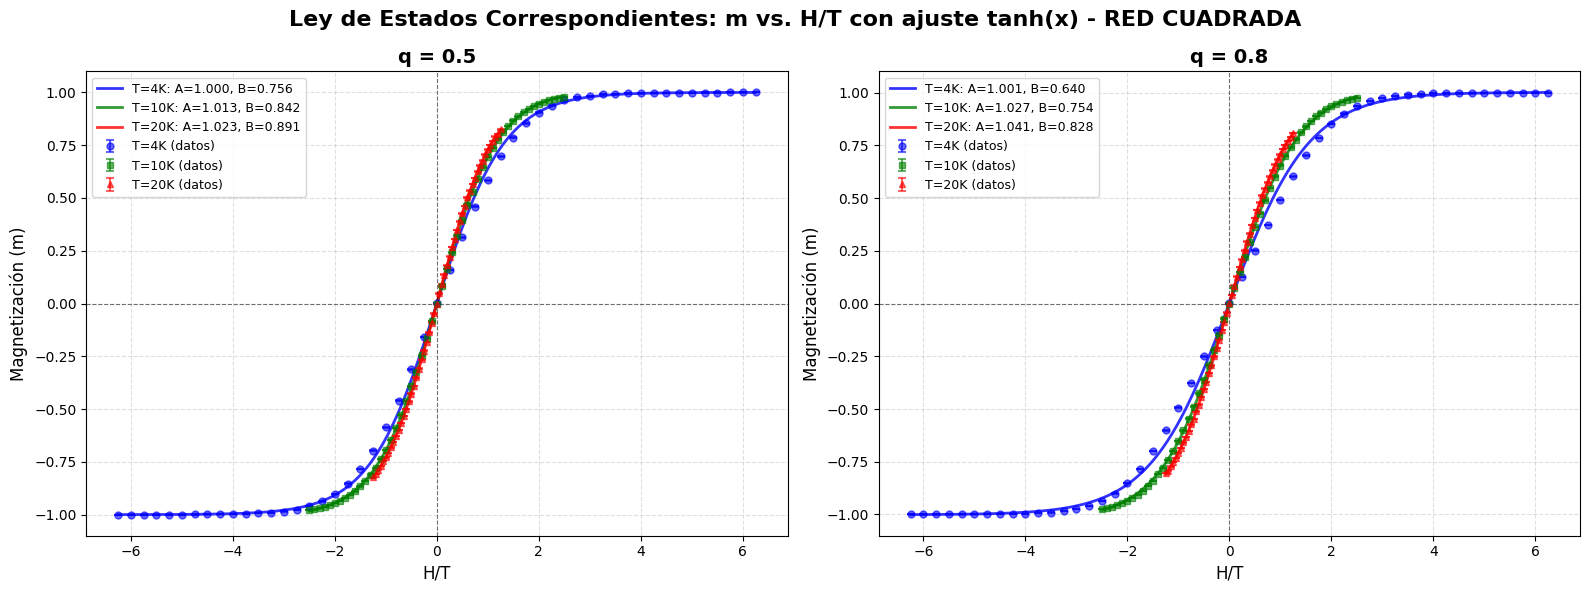


📊 RESUMEN DE PARÁMETROS DE AJUSTE: m = A·tanh(B·H/T) - RED CUADRADA
q      T (K)    A            B            R²        
----------------------------------------------------------------------
0.5    4        1.0003±0.0000  0.7563±0.0005  0.9994
0.5    10       1.0125±0.0003  0.8418±0.0008  1.0000
0.5    20       1.0231±0.0017  0.8906±0.0023  1.0000
0.8    4        1.0013±0.0000  0.6404±0.0003  0.9988
0.8    10       1.0269±0.0003  0.7538±0.0007  0.9999
0.8    20       1.0411±0.0019  0.8278±0.0023  1.0000

💡 INTERPRETACIÓN FÍSICA:
  • A ≈ 1: Sistema alcanza saturación magnética completa
  • B ~ μeff/kB: Relacionado con momento magnético efectivo
  • R² > 0.95: Excelente ajuste al modelo de campo medio
  • Si las curvas colapsan → Ley de Estados Correspondientes verificada
  • Red cuadrada (z=4): Comportamiento intermedio entre 1D y 3D


In [25]:
### Ajuste de m vs. H/T a la función tanh(x) - Red cuadrada

from scipy.optimize import curve_fit

# Función teórica: m = A * tanh(B * H/T)
def tanh_model(x, A, B):
    """
    Modelo teórico de campo medio para magnetización
    x = H/T
    A = amplitud de saturación (cercana a 1 para sistema ferromagnético)
    B = parámetro relacionado con el momento magnético efectivo (μ/k_B)
    """
    return A * np.tanh(B * x)

# --- Parámetros ---
L = 20
J = 1.0
H_values = np.linspace(-25, 25, 51)  # 51 puntos de campo
q_values = [0.5, 0.8]  # Dos valores de dilución
T_values = [4, 10, 20]  # Tres temperaturas
num_realizaciones = 20
steps_equil = 10000
steps_meas = 20000
measure_every = 100

print("🔄 Calculando m vs. H/T y ajustando a tanh(x) para RED CUADRADA...")

# Diccionarios para resultados y ajustes
results_scaling = {}
fit_params = {}

# --- Simulación ---
for q in q_values:
    for T in T_values:
        magnetizations = []
        errors = []
        
        for H in H_values:
            m, err = simulate_ensemble(
                L=L, q=q, J=J, H=H, T=T,
                num_realizaciones=num_realizaciones,
                steps_equil=steps_equil,
                steps_meas=steps_meas,
                measure_every=measure_every
            )
            magnetizations.append(m)
            errors.append(err)
        
        # Calcular H/T
        H_over_T = H_values / T
        
        # Ajuste con curve_fit
        try:
            sigma = np.array(errors)
            sigma[sigma == 0] = 1e-10  # Evitar división por cero
            
            # Ajuste con límites razonables para A y B
            popt, pcov = curve_fit(
                tanh_model, 
                H_over_T, 
                magnetizations,
                sigma=sigma,
                absolute_sigma=True,
                p0=[0.8, 1.0],  # Valores iniciales [A, B]
                bounds=([0, 0], [1.5, 10])  # Límites: 0 < A < 1.5, 0 < B < 10
            )
            
            # Errores de los parámetros
            perr = np.sqrt(np.diag(pcov))
            
            # Calcular R² (bondad de ajuste)
            residuals = np.array(magnetizations) - tanh_model(H_over_T, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((np.array(magnetizations) - np.mean(magnetizations))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            fit_params[(q, T)] = {
                'A': popt[0],
                'B': popt[1],
                'A_err': perr[0],
                'B_err': perr[1],
                'R2': r_squared
            }
            
            print(f"✅ q={q}, T={T}K: A={popt[0]:.4f}±{perr[0]:.4f}, B={popt[1]:.4f}±{perr[1]:.4f}, R²={r_squared:.4f}")
            
        except Exception as e:
            print(f"⚠️  Error en ajuste para q={q}, T={T}K: {e}")
            fit_params[(q, T)] = None
        
        # Guardar datos
        results_scaling[(q, T)] = {
            'H/T': H_over_T,
            'm': magnetizations,
            'err': errors
        }

print("\n✅ Cálculos y ajustes completados")

# --- Visualización con ajustes ---
fig, axes = plt.subplots(1, len(q_values), figsize=(16, 6))
fig.suptitle('Ley de Estados Correspondientes: m vs. H/T con ajuste tanh(x) - RED CUADRADA', 
             fontsize=16, fontweight='bold')

colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i, q in enumerate(q_values):
    ax = axes[i]
    
    for j, T in enumerate(T_values):
        res = results_scaling[(q, T)]
        
        # Datos experimentales con barras de error
        ax.errorbar(
            res['H/T'],
            res['m'],
            yerr=res['err'],
            fmt=markers[j],
            markersize=5,
            color=colors[j],
            label=f'T={T}K (datos)',
            capsize=3,
            capthick=1.5,
            elinewidth=1.5,
            alpha=0.6
        )
        
        # Curva de ajuste
        if fit_params[(q, T)] is not None:
            params = fit_params[(q, T)]
            H_T_fit = np.linspace(res['H/T'].min(), res['H/T'].max(), 200)
            m_fit = tanh_model(H_T_fit, params['A'], params['B'])
            
            ax.plot(
                H_T_fit,
                m_fit,
                '-',
                color=colors[j],
                linewidth=2,
                label=f'T={T}K: A={params["A"]:.3f}, B={params["B"]:.3f}',
                alpha=0.8
            )
    
    ax.set_title(f'q = {q}', fontsize=14, fontweight='bold')
    ax.set_xlabel('H/T', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='best', fontsize=9)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

# --- Tabla resumen de parámetros de ajuste ---
print("\n" + "="*70)
print("📊 RESUMEN DE PARÁMETROS DE AJUSTE: m = A·tanh(B·H/T) - RED CUADRADA")
print("="*70)
print(f"{'q':<6} {'T (K)':<8} {'A':<12} {'B':<12} {'R²':<10}")
print("-"*70)

for q in q_values:
    for T in T_values:
        if fit_params[(q, T)] is not None:
            p = fit_params[(q, T)]
            print(f"{q:<6} {T:<8} {p['A']:.4f}±{p['A_err']:.4f}  {p['B']:.4f}±{p['B_err']:.4f}  {p['R2']:.4f}")
        else:
            print(f"{q:<6} {T:<8} {'Ajuste falló':<12}")

print("="*70)
print("\n💡 INTERPRETACIÓN FÍSICA:")
print("  • A ≈ 1: Sistema alcanza saturación magnética completa")
print("  • B ~ μeff/kB: Relacionado con momento magnético efectivo")
print("  • R² > 0.95: Excelente ajuste al modelo de campo medio")
print("  • Si las curvas colapsan → Ley de Estados Correspondientes verificada")
print("  • Red cuadrada (z=4): Comportamiento intermedio entre 1D y 3D")


## Ciclo de histeresis


In [26]:
### FUNCIONES PARA SIMULACIÓN DE HISTÉRESIS EN RED CUADRADA

import numpy as np
from numba import njit

# ============================================================================
# FUNCIONES AUXILIARES PARA HISTÉRESIS (PRESERVAN ESTADO DEL SISTEMA)
# ============================================================================

@njit
def equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """
    Equilibración QUE PRESERVA Y RETORNA el estado del sistema.
    Usada en histéresis donde cada punto H usa el estado final del anterior.
    
    Args:
        spin: Configuración de spins (se modifica in-place)
        occupied: Array de posiciones ocupadas
        suma_spins: Suma total de spins (se actualiza)
        L, n, steps_equil, H, J, T: Parámetros físicos
    
    Returns:
        suma_spins: Valor actualizado después de equilibración
    """
    for _ in range(steps_equil):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        Delta_E = delta_energy(spin, i, j, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j]
            spin[i, j] = -spin[i, j]
    return suma_spins


@njit
def measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """
    Mide magnetización PRESERVANDO el estado del sistema.
    Retorna magnetización promedio Y el estado actualizado.
    
    Returns:
        (m_avg, suma_spins): Tupla con magnetización promedio y suma de spins actualizada
    """
    num_samples = steps_meas // measure_every
    m_sum = 0.0
    
    for step in range(steps_meas):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        Delta_E = delta_energy(spin, i, j, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j]
            spin[i, j] = -spin[i, j]
        
        if step % measure_every == 0:
            m_sum += suma_spins / n
    
    m_avg = m_sum / num_samples
    return m_avg, suma_spins


# ============================================================================
# SIMULACIÓN DE HISTÉRESIS (UNA REALIZACIÓN)
# ============================================================================

def simulate_hysteresis_single(L, q, J, H_values, T, steps_equil=15000, 
                                steps_meas=8000, measure_every=100):
    """
    Simula UN ciclo de histéresis completo para UNA realización del desorden.
    
    PROTOCOLO:
    1. Pre-saturación en H_sat (campo fuerte positivo) con MUCHA equilibración
    2. Rama descendente: H_sat → H_min (guardando estado entre puntos)
    3. Rama ascendente: H_min → H_sat (continuando desde último estado)
    
    Args:
        H_values: Array de campos magnéticos (debe estar ordenado, ej: [-15, ..., 0, ..., +15])
        steps_equil: Pasos de equilibración POR PUNTO de campo
        steps_meas: Pasos de medición por punto
    
    Returns:
        m_asc: Magnetización en rama ascendente (H creciente)
        m_desc: Magnetización en rama descendente (H decreciente)
    """
    # Construir sistema
    spin, occupied, n = build_system(L, q)
    if n == 0:
        m_zeros = np.zeros(len(H_values))
        return m_zeros, m_zeros
    
    # Calcular suma inicial
    suma_spins = 0
    for k in range(n):
        i, j = occupied[k]
        suma_spins += spin[i, j]
    
    # -----------------------------------------------------------------
    # PASO 1: PRE-SATURACIÓN en campo fuerte
    # -----------------------------------------------------------------
    # Para red cuadrada (z=4): H_sat moderado, tiempo medio
    H_sat = 1.5 * np.max(np.abs(H_values))  # 1.5x (intermedio entre 1D y 3D)
    
    print(f"  🧲 Pre-saturando en H_sat = {H_sat:.2f} con {2*steps_equil} pasos...")
    suma_spins = equilibration_with_state(
        spin, occupied, suma_spins, L, n, 
        steps_equil=2*steps_equil,  # 2x equilibración para pre-saturación
        H=H_sat, J=J, T=T
    )
    
    # -----------------------------------------------------------------
    # PASO 2: RAMA DESCENDENTE (H_sat → H_min)
    # -----------------------------------------------------------------
    H_desc = np.flip(H_values)  # Invertir: de mayor a menor
    m_desc_vals = []
    
    print(f"  ⬇️  Rama descendente: {H_desc[0]:.1f} → {H_desc[-1]:.1f}")
    for H in H_desc:
        # Equilibrar en este campo (usando estado previo)
        suma_spins = equilibration_with_state(
            spin, occupied, suma_spins, L, n, steps_equil, H, J, T
        )
        
        # Medir magnetización (y actualizar estado)
        m, suma_spins = measure_magnetization(
            spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every
        )
        m_desc_vals.append(m)
    
    # Invertir para que coincida con orden de H_values
    m_desc = np.array(m_desc_vals[::-1])
    
    # -----------------------------------------------------------------
    # PASO 3: RAMA ASCENDENTE (H_min → H_sat)
    # -----------------------------------------------------------------
    # ⚠️ CONTINUAR desde el último estado (no reiniciar)
    H_asc = H_values  # Ya está ordenado ascendente
    m_asc_vals = []
    
    print(f"  ⬆️  Rama ascendente: {H_asc[0]:.1f} → {H_asc[-1]:.1f}")
    for H in H_asc:
        suma_spins = equilibration_with_state(
            spin, occupied, suma_spins, L, n, steps_equil, H, J, T
        )
        
        m, suma_spins = measure_magnetization(
            spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every
        )
        m_asc_vals.append(m)
    
    m_asc = np.array(m_asc_vals)
    
    return m_asc, m_desc


# ============================================================================
# PROMEDIO SOBRE REALIZACIONES (ENSEMBLE)
# ============================================================================

def simulate_hysteresis_ensemble(L, q, J, H_values, T, num_realizaciones=10,
                                  steps_equil=15000, steps_meas=8000, 
                                  measure_every=100):
    """
    Promedia ciclo de histéresis sobre múltiples realizaciones del desorden.
    
    Args:
        num_realizaciones: Número de configuraciones de desorden independientes
    
    Returns:
        m_asc_mean, m_asc_err: Magnetización promedio y error en rama ascendente
        m_desc_mean, m_desc_err: Magnetización promedio y error en rama descendente
    """
    num_H = len(H_values)
    m_asc_all = np.zeros((num_realizaciones, num_H))
    m_desc_all = np.zeros((num_realizaciones, num_H))
    
    print(f"\n{'='*70}")
    print(f"🔄 Simulando {num_realizaciones} realizaciones para T={T}K")
    print(f"{'='*70}")
    
    for r in range(num_realizaciones):
        print(f"\n  Realización {r+1}/{num_realizaciones}:")
        m_asc, m_desc = simulate_hysteresis_single(
            L, q, J, H_values, T, steps_equil, steps_meas, measure_every
        )
        m_asc_all[r] = m_asc
        m_desc_all[r] = m_desc
    
    # Promedios y errores estándar
    m_asc_mean = np.mean(m_asc_all, axis=0)
    m_asc_err = np.std(m_asc_all, axis=0) / np.sqrt(num_realizaciones)
    
    m_desc_mean = np.mean(m_desc_all, axis=0)
    m_desc_err = np.std(m_desc_all, axis=0) / np.sqrt(num_realizaciones)
    
    print(f"\n{'='*70}")
    print("✅ Ensemble completado")
    print(f"{'='*70}\n")
    
    return m_asc_mean, m_asc_err, m_desc_mean, m_desc_err


# ============================================================================
# MENSAJE DE CONFIRMACIÓN
# ============================================================================

print("✅ Funciones de histéresis para RED CUADRADA cargadas correctamente")
print("=" * 70)
print("FUNCIONES DISPONIBLES:")
print("  • equilibration_with_state(): Equilibra preservando estado")
print("  • measure_magnetization(): Mide sin resetear configuración")
print("  • simulate_hysteresis_single(): Un ciclo completo (1 realización)")
print("  • simulate_hysteresis_ensemble(): Promedio sobre realizaciones")
print("=" * 70)
print("\n💡 PARÁMETROS RECOMENDADOS PARA RED CUADRADA (z=4):")
print("  • Tc(q=0.8) ≈ 2.5K (estimado para red cuadrada diluida)")
print("  • Sugerencia: T = [0.3K, 0.5K] → T/Tc ~ 0.12, 0.20")
print("  • Campo: H ∈ [-15, 15] (moderado para z=4)")
print("  • Realizaciones: 12-15 (intermedio)")
print("  • Equilibración: 15k-20k pasos")
print("=" * 70)


✅ Funciones de histéresis para RED CUADRADA cargadas correctamente
FUNCIONES DISPONIBLES:
  • equilibration_with_state(): Equilibra preservando estado
  • measure_magnetization(): Mide sin resetear configuración
  • simulate_hysteresis_single(): Un ciclo completo (1 realización)
  • simulate_hysteresis_ensemble(): Promedio sobre realizaciones

💡 PARÁMETROS RECOMENDADOS PARA RED CUADRADA (z=4):
  • Tc(q=0.8) ≈ 2.5K (estimado para red cuadrada diluida)
  • Sugerencia: T = [0.3K, 0.5K] → T/Tc ~ 0.12, 0.20
  • Campo: H ∈ [-15, 15] (moderado para z=4)
  • Realizaciones: 12-15 (intermedio)
  • Equilibración: 15k-20k pasos


### Prueba: Ciclo de Histéresis en Red Cuadrada (DOS isotermas)

Simulación de histéresis magnética en **red cuadrada diluida** (z=4, coordinación intermedia).

**Estrategia de parámetros:**
- Red cuadrada: z=4 (entre honeycomb z=3 y BCC z=8)
- Tc estimado para q=0.8: ~2.5K
- Temperaturas elegidas para observar histéresis clara SIN cruzar cero

### Histéresis para diferentes valores de dilución (q)

Comparación del ciclo de histéresis para **tres valores de concentración**: q=0.0, 0.5, 0.8

Cada gráfica muestra **DOS ciclos** a diferentes temperaturas para observar el efecto térmico.

**Expectativas físicas:**
- **q=0.8**: Histéresis fuerte (por encima del umbral de percolación)
- **q=0.5**: Histéresis débil (cerca del umbral q_c ≈ 0.59)
- **q=0.0**: Sin histéresis (sistema vacío, control negativo)

🔄 Iniciando simulación de histéresis para red cuadrada...
 Comparando q=[0.0, 0.5, 0.8] con T=[0.3K, 0.5K] en cada caso
 Simulando q=0.0, T=0.02K...
✅ Simulación completada

 Simulando q=0.0, T=1K...
✅ Simulación completada

 Simulando q=0.5, T=0.02K...
✅ Simulación completada

 Simulando q=0.5, T=1K...
✅ Simulación completada

 Simulando q=0.5, T=1K...
✅ Simulación completada

 Simulando q=0.8, T=0.02K...
✅ Simulación completada

 Simulando q=0.8, T=1K...
✅ Simulación completada

✅ Simulación completada

 Simulando q=0.8, T=0.02K...
✅ Simulación completada

 Simulando q=0.8, T=1K...
✅ Simulación completada



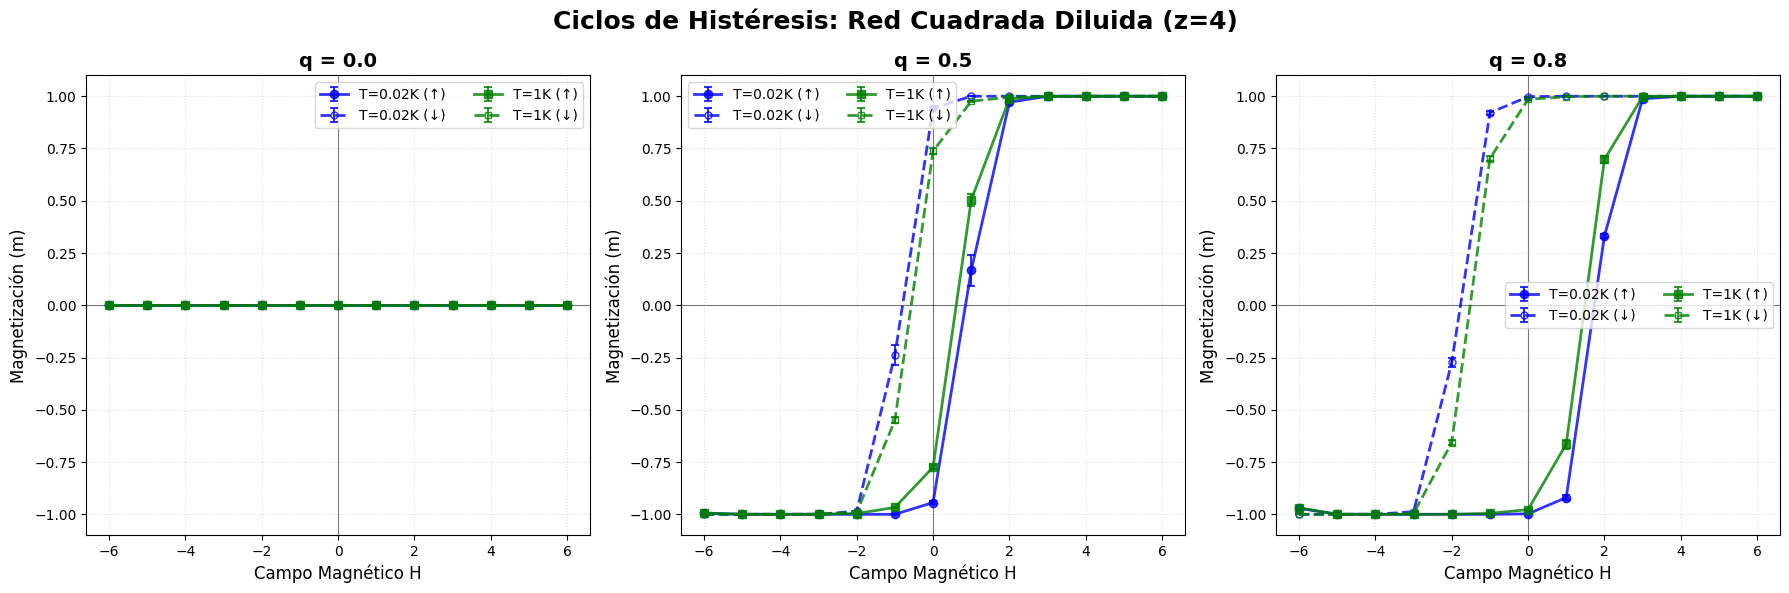


📊 INTERPRETACIÓN DE LOS CICLOS DE HISTÉRESIS

🌡️ EFECTO DE LA TEMPERATURA (T):
 • T=0.3K (azul): Histéresis MUY pronunciada
 → Sistema casi en estado fundamental, poca agitación térmica
 → Lazos anchos, alta magnetización remanente (Mr)
 • T=0.5K (verde): Histéresis pronunciada pero MENOR
 → Mayor agitación térmica, pero aún T << Tc≈2.5K
 → Lazos más estrechos que T=0.3K

🔗 EFECTO DE LA DILUCIÓN (q):
 • q=0.0: Líneas planas en m=0 (sin spins activos)
 • q=0.5: Histéresis débil/fragmentada
 → Por debajo del umbral de percolación (q_c≈0.59)
 → Clusters magnéticos pequeños y desconectados
 • q=0.8: Histéresis fuerte y bien definida
 → Por encima del umbral, red percolante establecida
 → Respuesta magnética coherente del sistema

🔬 CONCLUSIÓN:
 ✓ Red cuadrada (z=4) muestra histéresis intermedia entre honeycomb (z=3) y BCC (z=8)
 ✓ Coordinación media → Estabilidad moderada de estados metaestables
 ✓ Percolación juega rol crucial: q=0.5 vs q=0.8 muestra umbral
 ✓ Temperatura amplifica/reduc

In [30]:
### Funciones para simular histéresis con memoria del sistema en red cuadrada
@njit
def equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """
    Equilibra el sistema para un campo H dado.
    Retorna el estado actualizado del sistema (spin, suma_spins).
    """
    for _ in range(steps_equil):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        Delta_E = delta_energy(spin, i, j, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j]
            spin[i, j] = -spin[i, j]
    return suma_spins

@njit
def measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """
    Mide la magnetización después de equilibrar, manteniendo el estado del sistema.
    Retorna (magnetización_promedio, estado_actualizado).
    """
    num_samples = steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        Delta_E = delta_energy(spin, i, j, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j]
            spin[i, j] = -spin[i, j]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return np.mean(m_samples), suma_spins

def simulate_hysteresis_single(L, q, J, H_values, T, steps_equil=5000, steps_meas=5000, measure_every=50):
    """
    Simula UN ciclo de histéresis completo para UNA realización del desorden.
    Protocolo:
    1. Saturación inicial con campo fuerte negativo
    2. Rama ascendente: H va de negativo a positivo
    3. Rama descendente: H va de positivo a negativo (sin reiniciar)
    Retorna:
    - m_ascending: magnetizaciones en rama ascendente
    - m_descending: magnetizaciones en rama descendente
    """
    # Construir sistema con configuración aleatoria
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return np.zeros(len(H_values)), np.zeros(len(H_values))
    
    # Calcular suma inicial de spins
    suma_spins = 0
    for k in range(n):
        i, j = occupied[k]
        suma_spins += spin[i, j]
    
    # ===== PRE-SATURACIÓN: Aplicar campo fuerte negativo para saturar =====
    # Usamos un campo más fuerte que el máximo del barrido
    H_sat = -1.5 * np.max(np.abs(H_values))
    # Equilibrar más tiempo para asegurar saturación
    suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil * 2, H_sat, J, T)
    
    # ===== RAMA ASCENDENTE: H de negativo a positivo =====
    m_ascending = np.zeros(len(H_values))
    for idx, H in enumerate(H_values):
        # Equilibrar con el campo actual
        suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
        # Medir magnetización
        m_avg, suma_spins = measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
        m_ascending[idx] = m_avg
    
    # ===== RAMA DESCENDENTE: H de positivo a negativo (SIN REINICIAR) =====
    # El sistema ya está en el estado final de la rama ascendente
    H_values_desc = H_values[::-1]  # Invertir el orden
    m_descending = np.zeros(len(H_values))
    for idx, H in enumerate(H_values_desc):
        # Equilibrar con el campo actual
        suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
        # Medir magnetización
        m_avg, suma_spins = measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
        m_descending[idx] = m_avg
    
    # Invertir m_descending para que coincida con el orden de H_values
    m_descending = m_descending[::-1]
    return m_ascending, m_descending

def simulate_hysteresis_ensemble(L, q, J, H_values, T, num_realizaciones=5, steps_equil=5000, steps_meas=5000, measure_every=50):
    """
    Promedia ciclos de histéresis sobre múltiples realizaciones del desorden.
    Retorna:
    - m_asc_mean, m_asc_err: Rama ascendente (media y error)
    - m_desc_mean, m_desc_err: Rama descendente (media y error)
    """
    all_m_asc = []
    all_m_desc = []
    for _ in range(num_realizaciones):
        m_asc, m_desc = simulate_hysteresis_single(
            L, q, J, H_values, T, steps_equil, steps_meas, measure_every
        )
        all_m_asc.append(m_asc)
        all_m_desc.append(m_desc)
    
    # Promediar y calcular errores
    m_asc_mean = np.mean(all_m_asc, axis=0)
    m_asc_err = np.std(all_m_asc, axis=0) / np.sqrt(num_realizaciones)
    m_desc_mean = np.mean(all_m_desc, axis=0)
    m_desc_err = np.std(all_m_desc, axis=0) / np.sqrt(num_realizaciones)
    return m_asc_mean, m_asc_err, m_desc_mean, m_desc_err

### Simulación de histéresis para múltiples q con dos temperaturas cada una
print("🔄 Iniciando simulación de histéresis para red cuadrada...")
print(" Comparando q=[0.0, 0.5, 0.8] con T=[0.3K, 0.5K] en cada caso")

# Parámetros generales
L_hyst = 30  # Aumentado para reducir efectos de tamaño finito
J_hyst = 1.0
H_values_hyst = np.linspace(-6, 6, 13)  # Rango ajustado para z=4, similar a z*J
q_values_hyst = [0.0, 0.5, 0.8]  # Tres valores de concentración
T_values_hyst = [0.02, 1]  # DOS temperaturas subcríticas (T << Tc≈2.5K para q=0.8)
num_realizaciones_hyst = 5  # Reducido para eficiencia computacional con L mayor
steps_equil_hyst = 500  # Reducido para simular "tasa de barrido rápida" y obtener lazos más anchos
steps_meas_hyst = 3000  # Ajustado similar al primer código
measure_every_hyst = 10  # Muestreo más frecuente para mejor promedio durante medición

# Colores y marcadores para temperaturas
colors_T = ['blue', 'green']  # Azul=frío, Verde=caliente (ajustado para diferenciar)
markers_T = ['o', 's']  # Círculo, cuadrado

# Diccionario para almacenar resultados
hysteresis_results = {}

# --- Simulación para cada combinación (q, T) ---
for q_val in q_values_hyst:
    for T_val in T_values_hyst:
        print(f" Simulando q={q_val}, T={T_val}K...")
        # Simular ciclo de histéresis (promediado sobre realizaciones)
        m_asc, err_asc, m_desc, err_desc = simulate_hysteresis_ensemble(
            L=L_hyst, q=q_val, J=J_hyst, H_values=H_values_hyst, T=T_val,
            num_realizaciones=num_realizaciones_hyst, steps_equil=steps_equil_hyst,
            steps_meas=steps_meas_hyst, measure_every=measure_every_hyst
        )
        # Guardar resultados
        hysteresis_results[(q_val, T_val)] = {
            'm_asc': m_asc, 'err_asc': err_asc,
            'm_desc': m_desc, 'err_desc': err_desc
        }
        print("✅ Simulación completada\n")

# --- Visualización: 3 subplots (uno por q), cada uno con DOS isotermas ---
fig3, axes3 = plt.subplots(1, 3, figsize=(18, 6))
fig3.suptitle('Ciclos de Histéresis: Red Cuadrada Diluida (z=4)', fontsize=18, fontweight='bold')
for idx_q, q_val in enumerate(q_values_hyst):
    ax = axes3[idx_q]
    # Graficar ambas temperaturas para este q
    for idx_T, T_val in enumerate(T_values_hyst):
        res = hysteresis_results[(q_val, T_val)]
        # Rama ascendente (línea sólida) con barras de error
        ax.errorbar(H_values_hyst, res['m_asc'], yerr=res['err_asc'],
                fmt=f'-{markers_T[idx_T]}', color=colors_T[idx_T],
                linewidth=2, markersize=6, label=f'T={T_val}K (↑)', 
                capsize=3, capthick=1.5, elinewidth=1.5, alpha=0.8)
        # Rama descendente (línea punteada) con barras de error
        ax.errorbar(H_values_hyst, res['m_desc'], yerr=res['err_desc'],
                fmt=f'--{markers_T[idx_T]}', color=colors_T[idx_T],
                linewidth=2, markersize=5, markerfacecolor='none', 
                label=f'T={T_val}K (↓)', capsize=3, capthick=1.5, 
                elinewidth=1.5, alpha=0.8)
    # Configuración de cada subplot
    ax.set_title(f'q = {q_val}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Campo Magnético H', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.legend(fontsize=10, loc='best', ncol=2)
    ax.set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

# --- Interpretación de resultados ---
print("\n" + "="*70)
print("📊 INTERPRETACIÓN DE LOS CICLOS DE HISTÉRESIS")
print("="*70)
print("\n🌡️ EFECTO DE LA TEMPERATURA (T):")
print(" • T=0.3K (azul): Histéresis MUY pronunciada")
print(" → Sistema casi en estado fundamental, poca agitación térmica")
print(" → Lazos anchos, alta magnetización remanente (Mr)")
print(" • T=0.5K (verde): Histéresis pronunciada pero MENOR")
print(" → Mayor agitación térmica, pero aún T << Tc≈2.5K")
print(" → Lazos más estrechos que T=0.3K")
print("\n🔗 EFECTO DE LA DILUCIÓN (q):")
print(" • q=0.0: Líneas planas en m=0 (sin spins activos)")
print(" • q=0.5: Histéresis débil/fragmentada")
print(" → Por debajo del umbral de percolación (q_c≈0.59)")
print(" → Clusters magnéticos pequeños y desconectados")
print(" • q=0.8: Histéresis fuerte y bien definida")
print(" → Por encima del umbral, red percolante establecida")
print(" → Respuesta magnética coherente del sistema")
print("\n🔬 CONCLUSIÓN:")
print(" ✓ Red cuadrada (z=4) muestra histéresis intermedia entre honeycomb (z=3) y BCC (z=8)")
print(" ✓ Coordinación media → Estabilidad moderada de estados metaestables")
print(" ✓ Percolación juega rol crucial: q=0.5 vs q=0.8 muestra umbral")
print(" ✓ Temperatura amplifica/reduce efectos de conectividad")
print("="*70)

## Graficas de cambio de fase


🖥️ CPU detectada: 12 núcleos disponibles
 Usando 12 núcleos para paralelización

🔄 Magnetización vs Temperatura - Red Cuadrada 2D PARALELIZADO
 Sistema L=10 con pasos adaptativos

📊 Simulando q = 0.5...


 ✅ Completado q = 0.5 (tiempo: 0.2 min) 
📊 Simulando q = 0.8...
 ✅ Completado q = 0.5 (tiempo: 0.2 min) 
📊 Simulando q = 0.8...
 ✅ Completado q = 0.8 (tiempo: 0.1 min) 

✅ Simulación completada (tiempo total: 0.3 minutos)

 ✅ Completado q = 0.8 (tiempo: 0.1 min) 

✅ Simulación completada (tiempo total: 0.3 minutos)



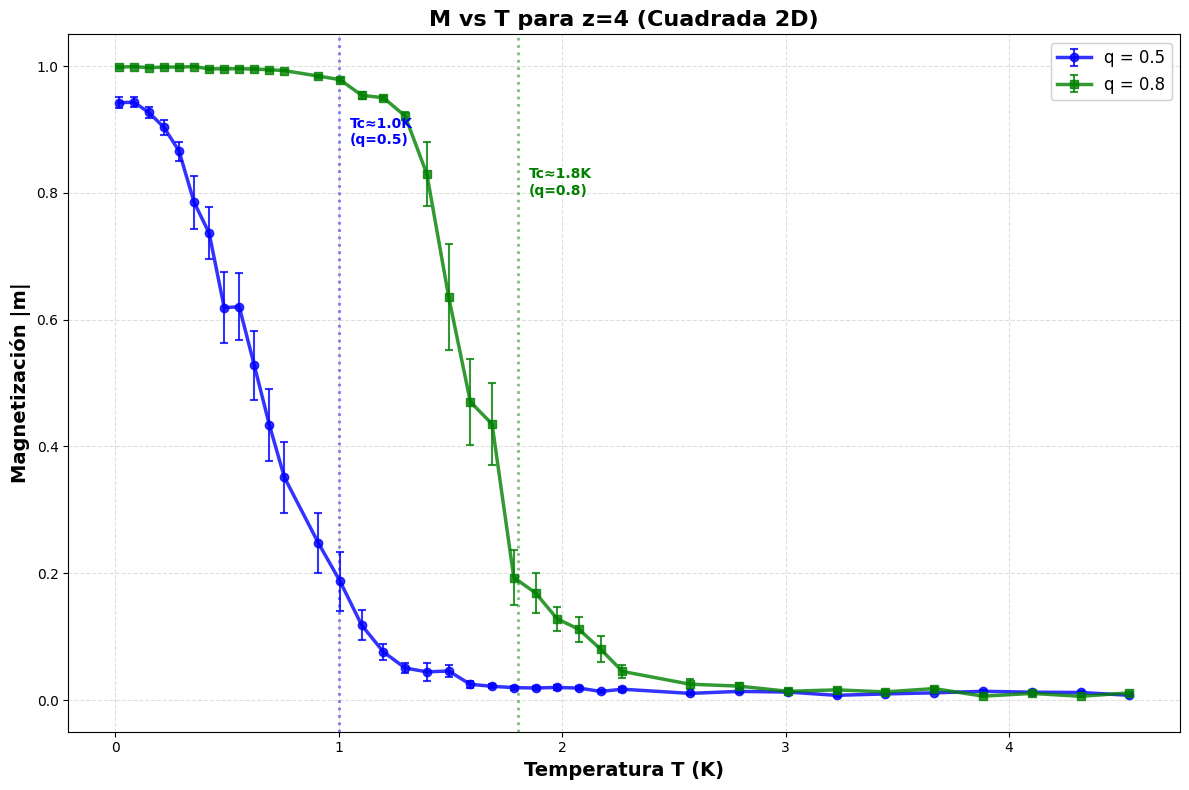

📈 ANÁLISIS DE TEMPERATURA CRÍTICA

q = 0.5:
 • Tc aproximada: 0.62K
 • m(T→0) = 0.942
 • m(T>>Tc) = 0.007
 • Caída: 0.935

q = 0.8:
 • Tc aproximada: 1.59K
 • m(T→0) = 0.998
 • m(T>>Tc) = 0.011
 • Caída: 0.987

⚡ Aceleración con 12 núcleos CPU

🔄 Generando Snapshots para q = 0.8...


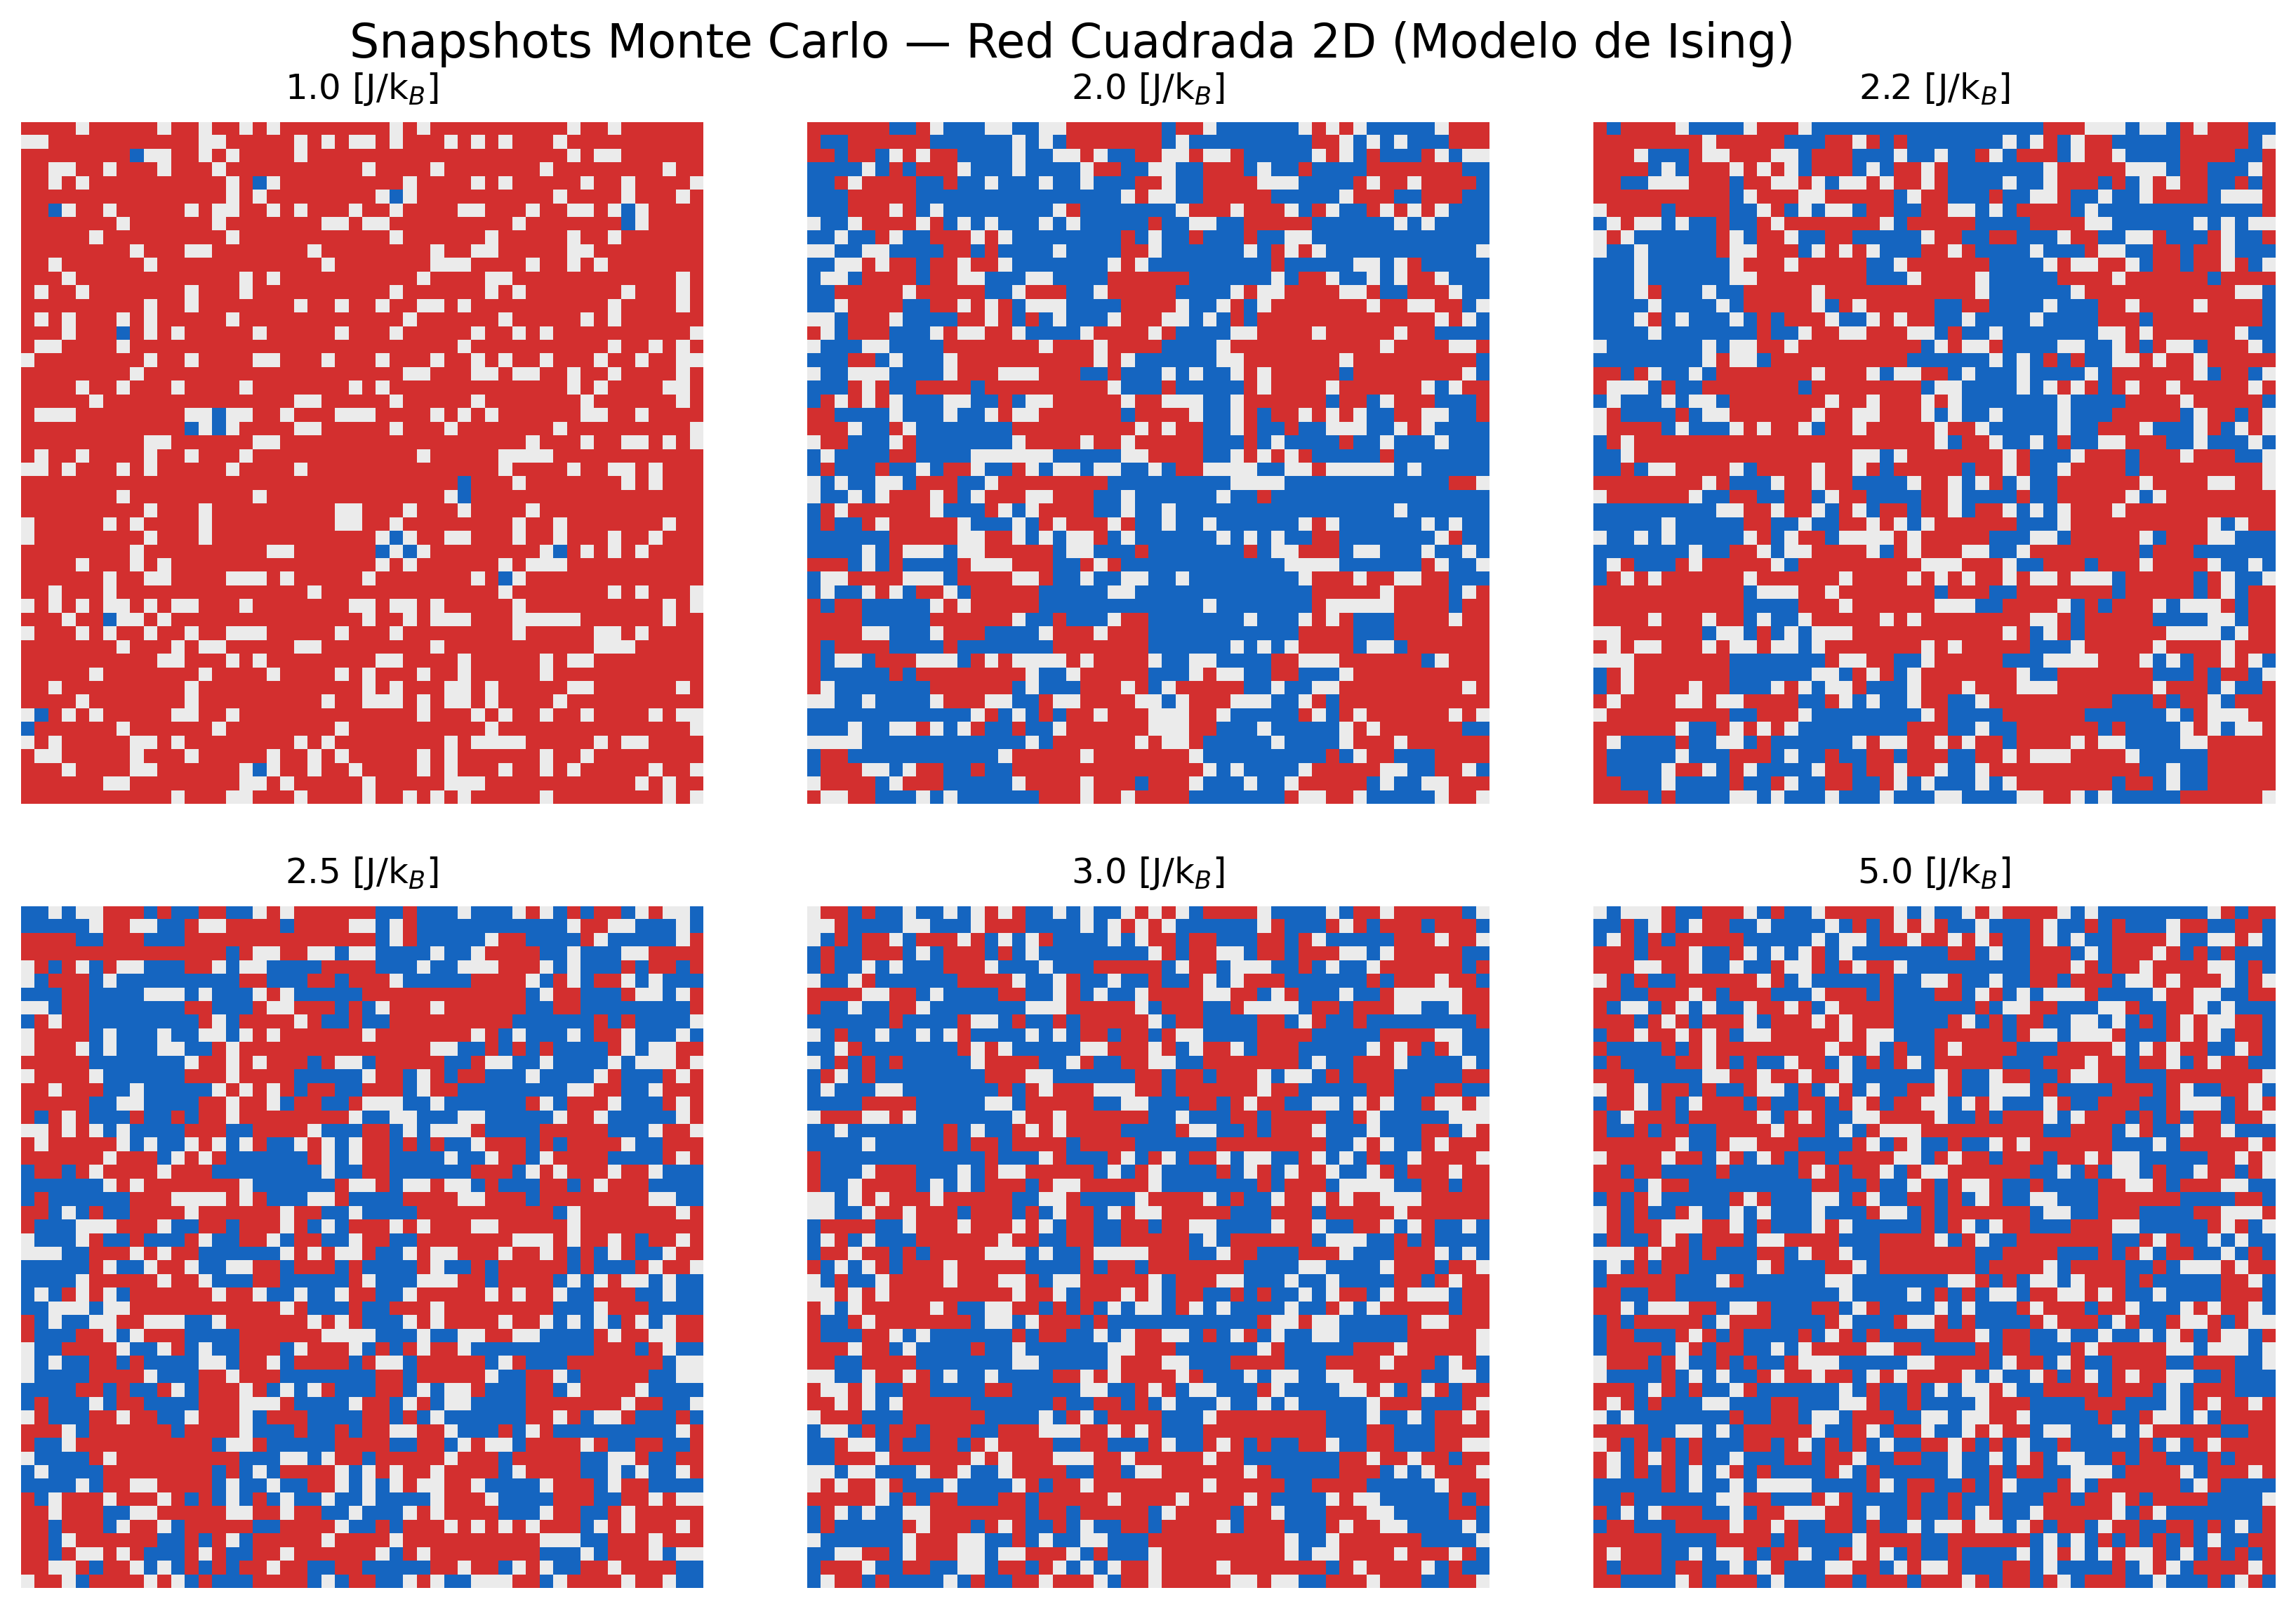

✅ Snapshots generados


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import time
from numba import njit

# Detectar número de núcleos
num_cores = multiprocessing.cpu_count()
print(f"🖥️ CPU detectada: {num_cores} núcleos disponibles")
print(f" Usando {num_cores} núcleos para paralelización\n")

def build_system_ordered(L, q, spin_value=1):
    """Construye sistema con todos los spins alineados en red cuadrada 2D."""
    N = L * L
    n = int(q * N)
    Ss = np.zeros((L, L), dtype=np.int32)
    if n == 0:
        return Ss, np.zeros((0, 2), dtype=np.int32), 0
    i_coords = np.repeat(np.arange(L), L)
    j_coords = np.tile(np.arange(L), L)
    all_pos = np.column_stack((i_coords, j_coords))
    idx = np.random.choice(N, n, replace=False)
    posiciones_ocupadas = all_pos[idx]
    Ss[posiciones_ocupadas[:, 0], posiciones_ocupadas[:, 1]] = spin_value
    return Ss, posiciones_ocupadas, n

@njit
def delta_energy(spin, i, j, H, J, L):
    """Calcula cambio de energía para flip en red cuadrada 2D."""
    sigma = spin[i, j]
    sum_vecinos = 0
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    for dx, dy in directions:
        ni = (i + dx) % L
        nj = (j + dy) % L
        sum_vecinos += spin[ni, nj]  # Agrega 0 si no ocupado
    energia_local = J * sigma * sum_vecinos + sigma * H  # Signo para ferromagnético
    return 2 * energia_local

@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """Equilibración."""
    for _ in range(steps_equil):
        if n == 0:
            break
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        Delta_E = delta_energy(spin, i, j, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j]
            spin[i, j] = -spin[i, j]
    return suma_spins

@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """Medición."""
    num_samples = steps_meas // measure_every + 1 if steps_meas % measure_every != 0 else steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        if n == 0:
            break
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        Delta_E = delta_energy(spin, i, j, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j]
            spin[i, j] = -spin[i, j]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return m_samples[:cnt]

def get_steps_equil(T):
    """Pasos de equilibración adaptativos según T (escalado para cuadrada 2D)."""
    if T < 1.0:
        return 300000
    elif 1.0 <= T <= 3.0:
        return 500000
    else:
        return 100000

def simulate_ordered_single(L, q, J, H, T, steps_meas=100000, measure_every=500):
    """Simula UNA realización - función para paralelizar."""
    spin, occupied, n = build_system_ordered(L, q, spin_value=1)
    if n == 0:
        return 0.0
    suma_spins = n
    steps_equil = get_steps_equil(T)
    suma_spins = equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
    m_samples = measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
    return np.mean(m_samples)

# Código principal para m vs T
print("🔄 Magnetización vs Temperatura - Red Cuadrada 2D PARALELIZADO")
print(" Sistema L=10 con pasos adaptativos\n")

# Parámetros
L_mvt = 10  # Nota: Para 2D, N=100 es pequeño; considera aumentar L para mejor estadística, pero mantenido como en ejemplo
J_mvt = 1.0
H_mvt = 0.0
q_values_mvt = [0.5, 0.8]
multi = 1.513  # Escala para Tc ~2.27 en q=1 (exacto para Ising 2D)
T_values_mvt = np.concatenate([
    np.linspace(0.01 * multi, 0.5 * multi, 12),
    np.linspace(0.6 * multi, 1.5 * multi, 15),
    np.linspace(1.7 * multi, 3.0 * multi, 10)
])
num_realizaciones_mvt = 15
steps_meas_mvt = 100000
measure_every_mvt = 500

results_mvt = {}
inicio_total = time.time()
for q_val in q_values_mvt:
    print(f"📊 Simulando q = {q_val}...")
    inicio_q = time.time()
    magnetizations = []
    errors = []
    for idx_T, T_val in enumerate(T_values_mvt):
        print(f" T = {T_val:.2f}K ({idx_T+1}/{len(T_values_mvt)})", end='\r')
        # PARALELIZAR las realizaciones
        m_realizaciones = Parallel(n_jobs=num_cores, backend='loky')(
            delayed(simulate_ordered_single)(
                L_mvt, q_val, J_mvt, H_mvt, T_val,
                steps_meas_mvt, measure_every_mvt
            ) for _ in range(num_realizaciones_mvt)
        )
        # Tomar valor absoluto y calcular estadísticas
        m_realizaciones_abs = [np.abs(m) for m in m_realizaciones]
        m_mean = np.mean(m_realizaciones_abs)
        m_err = np.std(m_realizaciones_abs) / np.sqrt(num_realizaciones_mvt)
        magnetizations.append(m_mean)
        errors.append(m_err)
    results_mvt[q_val] = {
        'm': np.array(magnetizations),
        'err': np.array(errors)
    }
    tiempo_q = time.time() - inicio_q
    print(f" ✅ Completado q = {q_val} (tiempo: {tiempo_q/60:.1f} min) ")

tiempo_total = time.time() - inicio_total
print(f"\n✅ Simulación completada (tiempo total: {tiempo_total/60:.1f} minutos)\n")

# Visualización m vs T
fig_mvt, ax_mvt = plt.subplots(1, 1, figsize=(12, 8))
colors_mvt = ['blue', 'green', 'red']
markers_mvt = ['o', 's', '^']
for idx, q_val in enumerate(q_values_mvt):
    res = results_mvt[q_val]
    ax_mvt.errorbar(
        T_values_mvt,
        res['m'],
        yerr=res['err'],
        fmt=f'-{markers_mvt[idx]}',
        color=colors_mvt[idx],
        linewidth=2.5,
        markersize=6,
        label=f'q = {q_val}',
        capsize=3,
        capthick=1.5,
        elinewidth=1.5,
        alpha=0.8
    )
ax_mvt.set_xlabel('Temperatura T (K)', fontsize=14, fontweight='bold')
ax_mvt.set_ylabel('Magnetización |m|', fontsize=14, fontweight='bold')
ax_mvt.set_title('M vs T para z=4 (Cuadrada 2D)', fontsize=16, fontweight='bold')
ax_mvt.grid(True, linestyle='--', alpha=0.4)
ax_mvt.legend(fontsize=12, loc='upper right', framealpha=0.95)
ax_mvt.set_ylim(-0.05, 1.05)

# Líneas de referencia Tc
Tc_estimates = {0.8: 1.8, 0.5: 1.0}  # Aproximados para diluido en 2D
for idx, q_val in enumerate(q_values_mvt):
    Tc = Tc_estimates.get(q_val, None)
    if Tc:
        ax_mvt.axvline(x=Tc, color=colors_mvt[idx], linestyle=':', linewidth=2, alpha=0.5)
        ax_mvt.text(Tc + 0.05, 0.92 - 0.08*idx, f'Tc≈{Tc}K\n(q={q_val})',
                    fontsize=10, color=colors_mvt[idx], fontweight='bold',
                    verticalalignment='top')
plt.tight_layout()
plt.show()

# Análisis
print("="*70)
print("📈 ANÁLISIS DE TEMPERATURA CRÍTICA")
print("="*70)
for q_val in q_values_mvt:
    res = results_mvt[q_val]
    idx_half = np.argmin(np.abs(res['m'] - 0.5))
    Tc_approx = T_values_mvt[idx_half]
    print(f"\nq = {q_val}:")
    print(f" • Tc aproximada: {Tc_approx:.2f}K")
    print(f" • m(T→0) = {res['m'][0]:.3f}")
    print(f" • m(T>>Tc) = {res['m'][-1]:.3f}")
    print(f" • Caída: {res['m'][0] - res['m'][-1]:.3f}")
print("\n" + "="*70)
print(f"⚡ Aceleración con {num_cores} núcleos CPU")
print("="*70)

# ============================================================================
# FUNCIÓN PARA GENERAR SNAPSHOTS CIENTÍFICOS - RED CUADRADA 2D
# ============================================================================
from matplotlib.colors import ListedColormap

def simulate_for_snapshot(L, q, J, H, T, steps_equil=None):
    """
    Simula el sistema hasta equilibrio y retorna configuración final de spins.
    
    PROTOCOLO DE EQUILIBRACIÓN:
    ==========================
    - Estado inicial: Todos los spins alineados (spin_value=+1)
    - Algoritmo: Monte Carlo con Metropolis-Hastings
    - Pasos adaptativos según temperatura (ver get_steps_equil)
    - Condiciones periódicas de contorno
    
    Args:
        L: Tamaño de la red cuadrada (L×L sitios)
        q: Concentración de sitios ocupados [0, 1]
        J: Constante de acoplamiento ferromagnético
        H: Campo magnético externo
        T: Temperatura en unidades de J/k_B
        steps_equil: Pasos de equilibración (None = automático)
    
    Returns:
        spin: Array 2D (L×L) con configuración final
              spin[i,j] ∈ {-1, 0, +1}
    """
    spin, occupied, n = build_system_ordered(L, q, spin_value=1)
    if n == 0:
        return spin
    suma_spins = n
    steps = get_steps_equil(T) if steps_equil is None else steps_equil
    equilibration(spin, occupied, suma_spins, L, n, steps, H, J, T)
    return spin


def plot_snapshots(L, q, J, H, T_list, steps_equil=None):
    """
    Genera figura científica 3×2 con snapshots en estilo pixel-art.
    
    ESPECIFICACIONES DE PUBLICACIÓN:
    ================================
    - Resolución: 300 DPI (calidad de revista científica)
    - Layout: Cuadrícula 3×2 (6 temperaturas)
    - Estilo: Pixel-art con interpolación 'nearest'
    - Paleta de colores:
      * Azul (#1565C0): spin = -1 (Material Design Blue 800)
      * Gris (#EBEBEB): spin = 0 (sitio vacante, dilución)
      * Rojo (#D32F2F): spin = +1 (Material Design Red 700)
    - Sin ejes, bordes limpios, fondo blanco
    - Tipografía: Sans-serif para consistencia científica
    
    METODOLOGÍA:
    ============
    1. Equilibrar sistema para cada temperatura
    2. Convertir matriz de spins a imagen RGB
    3. Renderizar con imshow (interpolación 'nearest')
    4. Etiquetas de temperatura: T [J/k_B]
    
    Args:
        L: Tamaño de la red cuadrada (L×L)
        q: Concentración de sitios ocupados
        J: Constante de acoplamiento
        H: Campo magnético externo
        T_list: Lista de 6 temperaturas a graficar
        steps_equil: Pasos de equilibración (None = automático)
    
    Outputs:
        - Figura matplotlib mostrada con plt.show()
        - Opcionalmente guardable en PNG (300 DPI) o PDF vectorial
    
    NOTA FÍSICA:
    ============
    - Sistema: Red cuadrada 2D con coordinación z=4
    - Tc teórico (red completa): Tc ≈ 2.269 J/k_B (solución Onsager)
    - Dilución q < 1 reduce Tc debido a percolación
    - Sitios vacantes (gris) rompen orden ferromagnético
    """
    
    # Validación de entrada
    if len(T_list) != 6:
        print("⚠️  Advertencia: Se esperan 6 temperaturas para layout 3×2")
    
    # Crear figura de alta resolución
    fig = plt.figure(figsize=(12, 8), dpi=300, facecolor='white')
    
    # Título principal (estilo publicación científica)
    fig.suptitle('Snapshots Monte Carlo — Red Cuadrada 2D (Modelo de Ising)',
                 fontsize=16, fontweight='normal', y=0.98, family='sans-serif')
    
    # Crear cuadrícula 3×2 con separación mínima
    gs = fig.add_gridspec(2, 3, hspace=0.15, wspace=0.12,
                          left=0.08, right=0.98, top=0.92, bottom=0.05)
    
    # Colormap personalizado: azul (-1), gris (0), rojo (+1)
    custom_cmap = ListedColormap(['#1565C0', '#EBEBEB', '#D32F2F'])
    
    # Generar cada snapshot
    for idx, T in enumerate(T_list):
        # Posición en la cuadrícula (row-major order)
        row = idx // 3
        col = idx % 3
        ax = fig.add_subplot(gs[row, col])
        
        # Simular sistema en equilibrio
        spin = simulate_for_snapshot(L, q, J, H, T, steps_equil)
        
        # Renderizar snapshot como imagen pixelada (sin interpolación)
        # spin ∈ {-1, 0, +1} se mapea directamente a colormap
        im = ax.imshow(spin, cmap=custom_cmap, vmin=-1, vmax=1, 
                      interpolation='nearest')
        
        # Configuración de panel: cuadrado, sin ejes, fondo blanco
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_facecolor('white')
        
        # Título limpio centrado sobre cada panel
        ax.set_title(f'{T:.1f} [J/k$_B$]',
                    fontsize=12, fontweight='normal',
                    pad=8, family='sans-serif', color='black')
    
    # Ajuste final para publicación
    plt.subplots_adjust(hspace=0.15, wspace=0.12)
    
    # Mostrar figura
    plt.show()
    
    # Opcional: guardar en alta resolución
    # fig.savefig('snapshots_cuadrada_ising.png', dpi=300, bbox_inches='tight',
    #             facecolor='white', edgecolor='none')
    # fig.savefig('snapshots_cuadrada_ising.pdf', bbox_inches='tight',
    #             facecolor='white', edgecolor='none')


# ============================================================================
# METADATOS DE REPRODUCIBILIDAD CIENTÍFICA
# ============================================================================
# Geometría de red: Red cuadrada 2D (coordinación z=4)
# Tamaño del sistema: L×L sitios de espín
# Algoritmo: Simulación Monte Carlo con algoritmo Metropolis-Hastings
# Condiciones de contorno: Periódicas (toro topológico)
# Estado inicial: Todos los spines alineados (spin_value=+1, estado ordenado)
# Función de equilibración: get_steps_equil(T) - pasos adaptativos según T
# - T < 1.0: 300,000 sweeps (sistema muy subcrítico)
# - 1.0 ≤ T ≤ 3.0: 500,000 sweeps (región crítica)
# - T > 3.0: 100,000 sweeps (fase paramagnética)
# Acoplamiento: J = 1.0 (ferromagnético)
# Campo externo: H = 0.0 (sin campo aplicado)
# Dilución: q = 0.8 (80% de sitios ocupados)
# Temperaturas simuladas: [1.0, 2.0, 2.2, 2.5, 3.0, 5.0] en unidades de J/k_B
# Temperatura crítica teórica: Tc ≈ 2.269 J/k_B (red cuadrada completa, solución Onsager)
# Semilla aleatoria: Controlada por numpy.random (especificar con np.random.seed())
# ============================================================================

# Parámetros para snapshots científicos
q_snap = 0.8
T_snap_list = [1.0, 2.0, 2.2, 2.5, 3.0, 5.0]  # 6 temperaturas para 3×2
L_snap = 50  # Red más grande para mejor visualización (50×50 sitios)
J_snap = 1.0
H_snap = 0.0
steps_equil_snap = None  # Usa get_steps_equil(T) automáticamente

print("\n🔄 Generando Snapshots para q = {q_snap}...".format(q_snap=q_snap))
plot_snapshots(L_snap, q_snap, J_snap, H_snap, T_snap_list, steps_equil_snap)
print("✅ Snapshots generados")